In [6]:
from data_structures import *
from shortest_path import RoutePlaner
from utlis import *
from utlis import *
import pickle
import importlib


with open("mpk_graph.pickle", "rb") as f:
    graph = pickle.load(f)


In [7]:
import random

def generate_random_test_cases(bus_stops_names, num_tests=10):
    test_cases = []
    
    for _ in range(num_tests):
        start_stop, end_stop = random.sample(bus_stops_names, 2) 
        departure_time = f"{random.randint(6, 21):02d}:{random.randint(0, 59):02d}:00"

        test_cases.append({
            "start_stop": start_stop,
            "end_stop": end_stop,
            "departure_time": departure_time
        })
    
    return test_cases


bus_stops_names = list(graph.keys())
test_cases = generate_random_test_cases(bus_stops_names, num_tests=1)

In [11]:
bus_stop_names = graph.keys()
wroclaw_route_planer = RoutePlaner(graph) 

In [10]:
import pandas as pd
import os

results = []
heuristics = [
    (wroclaw_route_planer.euclidean_distance_heuristic, "Euclidean Distance"),
    (wroclaw_route_planer.angle_between_heuristic, "Angle Between"),
    (wroclaw_route_planer.zero_heuristic, "Zero Heuristic"),
    (wroclaw_route_planer.haversine_distance_heuristic, "Haversine Distance")
]

def run_astar(start_stop, end_stop, departure_time, heuristic, heuristic_name, connection_finder_type=None):
    try:
        totaltime, route, visited_nodes, visited_connections = wroclaw_route_planer.astar(
            start_stop=start_stop,
            end_stop=end_stop,
            departure_time=departure_time,
            heuristic_function=heuristic,
            connection_finder_type=connection_finder_type
        )
        print("Total time: ", totaltime)
        results.append({
            "Start": start_stop,
            "End": end_stop,
            "Departure Time": departure_time,
            "Heuristic": heuristic_name,
            "Total Time": totaltime,
            "Visited Connections": visited_connections,
            "Visited nodes": visited_nodes,
            "Number of Transfers": calculate_number_of_transfers(route),
            "Route finding mode": connection_finder_type if connection_finder_type else "earliest"
        })
    except Exception as e:
        print(f"Error: {e}")
        pass

for test_case in test_cases:
    start_stop, end_stop, departure_time = test_case["start_stop"], test_case["end_stop"], test_case["departure_time"]
    
    for heuristic, heuristic_name in heuristics:
        run_astar(start_stop, end_stop, departure_time, heuristic, heuristic_name)
        
        if heuristic_name in {"Angle Between", "Euclidean Distance"}:
            run_astar(start_stop, end_stop, departure_time, heuristic, heuristic_name, connection_finder_type='no_change')



results_df = pd.DataFrame(results)
output_dir = "results"
output_file = "results.csv"
output_path = os.path.join(output_dir, output_file)

os.makedirs(output_dir, exist_ok=True)

if os.path.exists(output_path):
    base, ext = os.path.splitext(output_file)
    counter = 1
    while os.path.exists(output_path):
        output_file = f"{base}_{counter}{ext}"
        output_path = os.path.join(output_dir, output_file)
        counter += 1

results_df.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

Total time:  99.0
Total time:  99.0
Total time:  99.0
Total time:  99.0
Total time:  99.0
Total time:  99.0
Results saved to results/results.csv


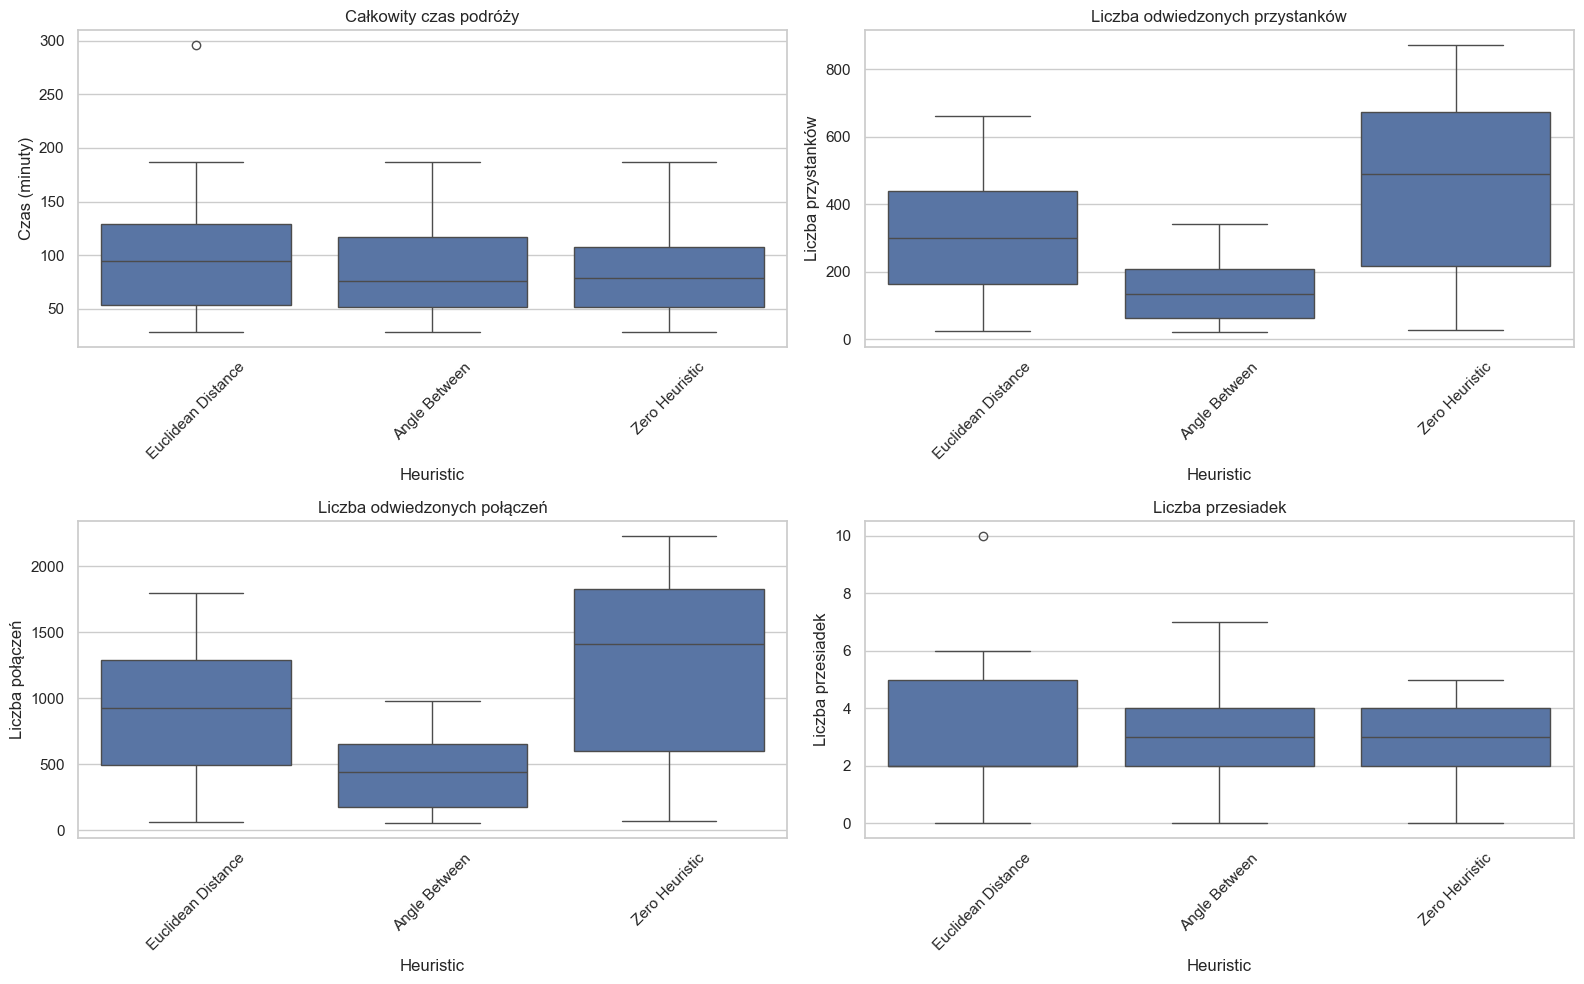

Statystyki porównawcze heurystyk:
                    Total Time                   Visited nodes         \
                          mean median        std          mean median   
Heuristic                                                               
Angle Between        87.944444   76.0  48.562237    141.944444  133.0   
Euclidean Distance  103.937500   94.5  70.269452    328.125000  301.0   
Zero Heuristic       85.833333   79.0  45.357728    450.500000  490.5   

                               Visited Connections                      \
                           std                mean  median         std   
Heuristic                                                                
Angle Between        97.158132          437.277778   441.5  286.542432   
Euclidean Distance  211.771851          946.625000   924.5  564.805793   
Zero Heuristic      257.745257         1246.277778  1411.0  667.811245   

                   Number of Transfers                   
                        

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ustawienie większego rozmiaru wykresu
plt.figure(figsize=(16, 10))

# 1. Porównanie całkowitego czasu podróży
plt.subplot(2, 2, 1)
sns.boxplot(x='Heuristic', y='Total Time', data=results_df)
plt.title('Całkowity czas podróży')
plt.xticks(rotation=45)
plt.ylabel('Czas (minuty)')

# 2. Porównanie liczby odwiedzonych węzłów
plt.subplot(2, 2, 2)
sns.boxplot(x='Heuristic', y='Visited nodes', data=results_df)
plt.title('Liczba odwiedzonych przystanków')
plt.xticks(rotation=45)
plt.ylabel('Liczba przystanków')

# 3. Porównanie liczby odwiedzonych połączeń
plt.subplot(2, 2, 3)
sns.boxplot(x='Heuristic', y='Visited Connections', data=results_df)
plt.title('Liczba odwiedzonych połączeń')
plt.xticks(rotation=45)
plt.ylabel('Liczba połączeń')

# 4. Porównanie liczby przesiadek
plt.subplot(2, 2, 4)
sns.boxplot(x='Heuristic', y='Number of Transfers', data=results_df)
plt.title('Liczba przesiadek')
plt.xticks(rotation=45)
plt.ylabel('Liczba przesiadek')

plt.tight_layout()
plt.show()

# Dodatkowe statystyki porównawcze
print("Statystyki porównawcze heurystyk:")
comparison_stats = results_df.groupby('Heuristic').agg({
    'Total Time': ['mean', 'median', 'std'],
    'Visited nodes': ['mean', 'median', 'std'],
    'Visited Connections': ['mean', 'median', 'std'],
    'Number of Transfers': ['mean', 'median', 'std']
})
print(comparison_stats)

# Agregacja statystyk dla każdej trasy
route_comparison = results_df.pivot_table(
    index=['Start', 'End'], 
    columns='Heuristic', 
    values=['Total Time', 'Visited nodes', 'Visited Connections', 'Number of Transfers']
)
print("\nPorównanie tras dla różnych heurystyk:")
print(route_comparison)

/var/folders/03/n179cc412h58x4qb9mt1bv_m0000gn/T/ipykernel_81710/171299467.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


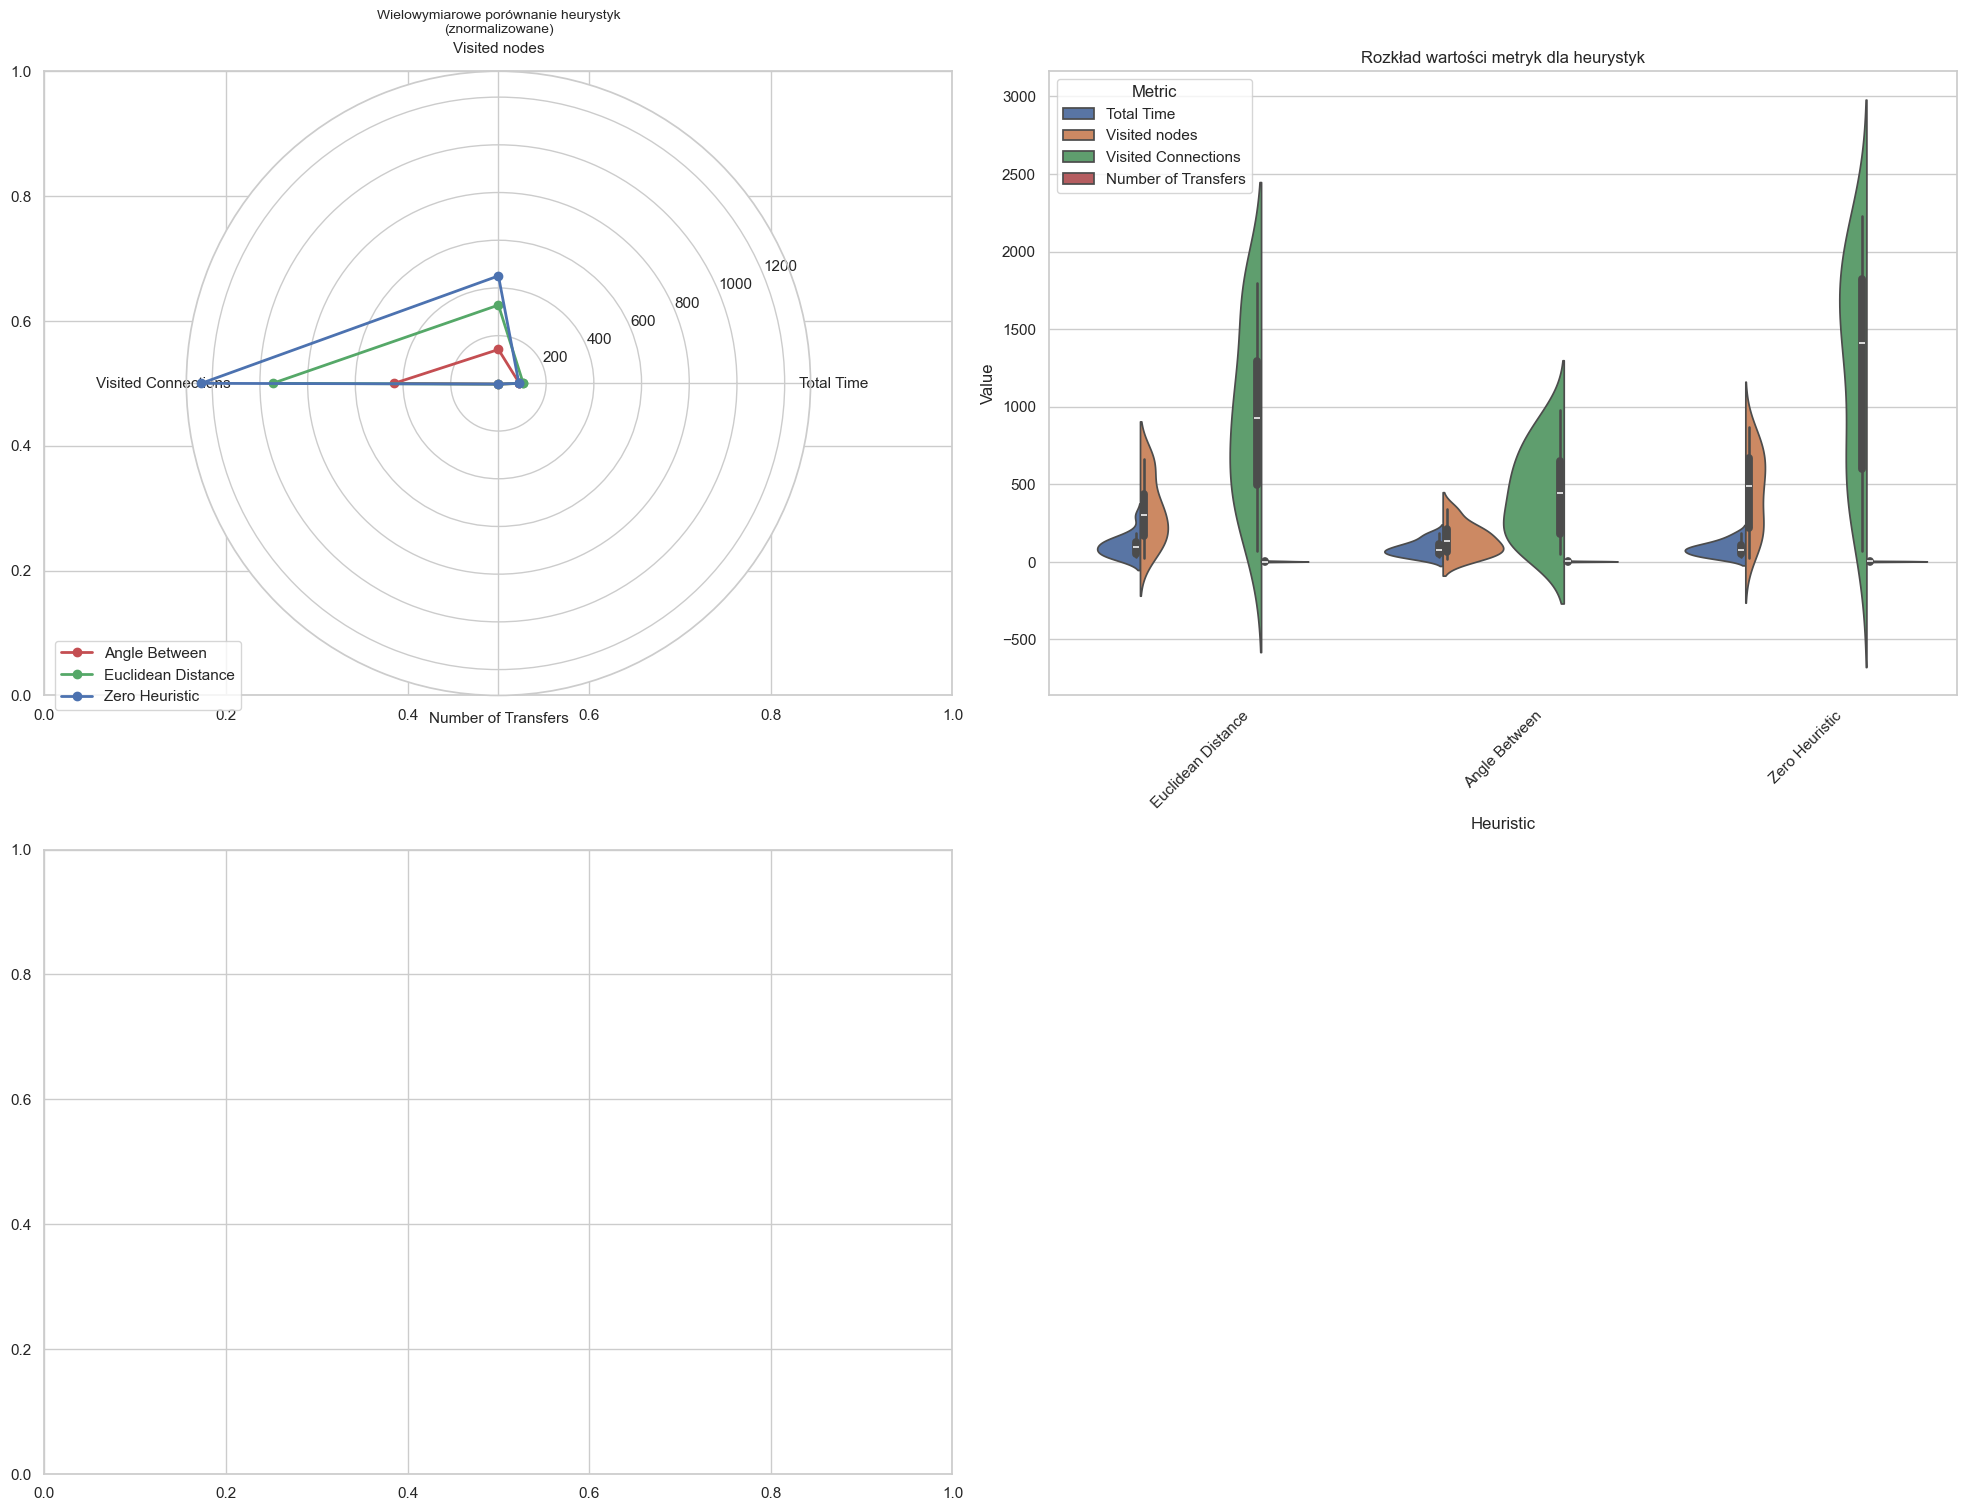

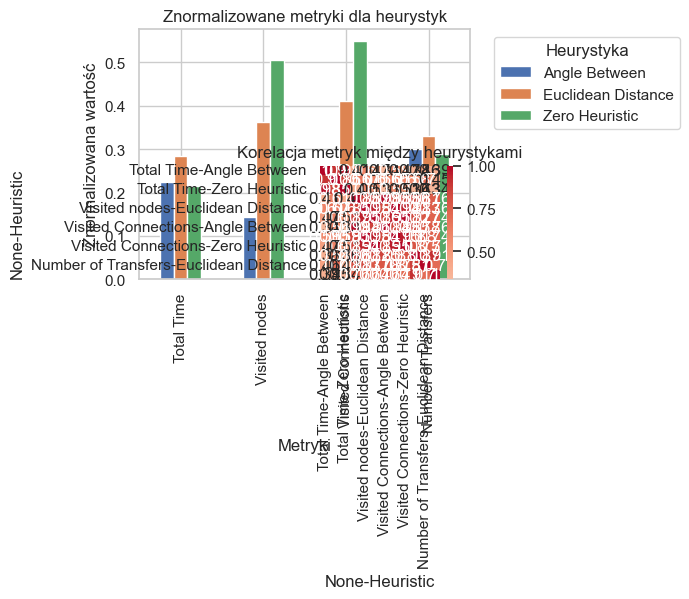


Statystyki opisowe dla heurystyk:
                    Total Time                   Visited nodes         \
                          mean median        std          mean median   
Heuristic                                                               
Angle Between        87.944444   76.0  48.562237    141.944444  133.0   
Euclidean Distance  103.937500   94.5  70.269452    328.125000  301.0   
Zero Heuristic       85.833333   79.0  45.357728    450.500000  490.5   

                               Visited Connections                      \
                           std                mean  median         std   
Heuristic                                                                
Angle Between        97.158132          437.277778   441.5  286.542432   
Euclidean Distance  211.771851          946.625000   924.5  564.805793   
Zero Heuristic      257.745257         1246.277778  1411.0  667.811245   

                   Number of Transfers                   
                       

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ustawienie stylu i rozmiaru
plt.figure(figsize=(20, 15))

# 1. Wielowymiarowy wykres radarowy
plt.subplot(2, 2, 1)
# Normalizacja danych
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Przygotowanie danych do wykresu radarowego
metrics = ['Total Time', 'Visited nodes', 'Visited Connections', 'Number of Transfers']
normalized_data = results_df.groupby('Heuristic')[metrics].mean()

# Przygotowanie wykresu radarowego
categories = metrics
N = len(categories)

# Kąty dla poszczególnych kategorii
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Inicjalizacja wykresu
plt.subplot(2, 2, 1, polar=True)
colors = ['r', 'g', 'b']
for i, (heuristic, row) in enumerate(normalized_data.iterrows()):
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, 'o-', linewidth=2, label=heuristic, color=colors[i])

plt.title('Wielowymiarowe porównanie heurystyk\n(znormalizowane)', size=10)
plt.xticks(angles[:-1], categories)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 2. Violin plot dla różnych metryk
plt.subplot(2, 2, 2)
metrics_to_plot = ['Total Time', 'Visited nodes', 'Visited Connections', 'Number of Transfers']
metrics_melted = results_df.melt(id_vars=['Heuristic'], value_vars=metrics_to_plot, 
                                  var_name='Metric', value_name='Value')

sns.violinplot(x='Heuristic', y='Value', hue='Metric', data=metrics_melted, split=True)
plt.title('Rozkład wartości metryk dla heurystyk')
plt.xticks(rotation=45)
plt.tight_layout()

# 3. Normalized stacked bar
plt.subplot(2, 2, 3)
# Normalizacja danych dla każdej metryki
normalized_df = results_df.copy()
for metric in metrics_to_plot:
    normalized_df[metric] = (normalized_df[metric] - normalized_df[metric].min()) / \
                             (normalized_df[metric].max() - normalized_df[metric].min())

# Grupowanie i średnie
normalized_grouped = normalized_df.groupby('Heuristic')[metrics_to_plot].mean()

normalized_grouped.T.plot(kind='bar', stacked=False)
plt.title('Znormalizowane metryki dla heurystyk')
plt.xlabel('Metryki')
plt.ylabel('Znormalizowana wartość')
plt.legend(title='Heurystyka', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# 4. Scatter matrix dla różnych heurystyk
plt.subplot(2, 2, 4)
metrics_for_scatter = ['Total Time', 'Visited nodes', 'Visited Connections', 'Number of Transfers']
scatter_df = results_df.pivot(index=['Start', 'End'], columns='Heuristic', values=metrics_for_scatter)

# Korelacja między heurystykami
correlation = scatter_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Korelacja metryk między heurystykami')

plt.tight_layout()
plt.show()

# Dodatkowe statystyki
print("\nStatystyki opisowe dla heurystyk:")
print(results_df.groupby('Heuristic')[metrics_to_plot].agg(['mean', 'median', 'std']))